## Imports

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Cargamos los datos

In [37]:
import pandas as pd

data = pd.read_excel("Wind data for TP1.xlsx")

data.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


## Constantes

In [58]:
YEARS = 10
PI = np.pi
DELTA = 1/365

S0 = data["regional wind"][0]
K = 3
SIGMA = 1

GAMMA = 1
D0 = data["wind gap norte sur"][0]

### Modelo Molino

In [34]:
# modelo del molino
# Si+1 = Si + κ(θ(ti) −Si)∆ + σ√∆ Zi (1)
# Si+1  - Si = κ(θ(ti) −Si)∆ + σ√∆ Zi 


In [35]:
def trend(i):
    return 6 +  2* np.cos(2 * PI * i / 365)

def nextDay(i ,Si ,K ,sigma):
    return Si + K*(trend(i) - Si) * DELTA + sigma * DELTA**0.5 * np.random.normal(0,1)


def simulateTrip(days, k , sigma, S0 = 8):
    days = np.arange(0, 365 * YEARS, 1)
    shoks = np.random.normal(0, 1, len(days))
    trip = [S0]
    for i in days:
        Si = trip[-1]
        trip.append(nextDay(i,Si, k, sigma))
    return trip


In [36]:
# Diferencia entre molinos

#Di+1 = Di −βDi∆ + γ√∆ Wi (2)
#Di+1 - Di = βDi∆ + 0 (2)

# Diferencia entre molinos
#Di+1 = Di −βDi∆ + γ√∆ Wi (2)

def diffNextDay(Di, beta, gamma):
    return Di - beta * Di * DELTA + gamma * DELTA**0.5 * np.random.normal(0,1)

def simulateDiffTrip(beta, gamma):
    days = np.arange(0, 365 * YEARS, 1)
    trip = [0]
    for i in days:
        a = diffNextDay(trip[-1], beta, gamma)
        # print(type(a))
        trip.append(diffNextDay(trip[-1], beta, gamma))
    return trip



In [38]:
# new column with the diff between one day and the previous one

data["diff_wind"] = data["regional wind"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_wind
0,1,8.000000,0.000000,0.346296
1,2,8.346296,0.181523,1.716019
2,3,10.062316,0.188643,0.729021
3,4,10.791337,0.071085,-0.037244
4,5,10.754093,0.078442,0.017364


## Regresion Lineal

In [39]:
data["regional wind"][:-1].index.values

array([   0,    1,    2, ..., 3646, 3647, 3648])

In [40]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Supongamos que tienes los datos en un DataFrame
# df['S'] es la columna de la variable S
# df['theta'] es la columna de la variable θ(t)
# Δ es el tamaño de paso del tiempo

# Si+1  - Si = κ(θ(ti) −Si)∆ + σ√∆ Zi 

# Calcular las diferencias Y_i = S_{i+1} - S_i
data['diff_wind'] = data['regional wind'].diff().shift(-1)

# Calcular X1_i = (θ(t_i) - S_i) * Δ
data['X1'] = (trend(data["regional wind"][:-1].index.values) - data["regional wind"][:-1]) * DELTA

# Calcular Z_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de Z_i, si no, deberás calcularla
# Z_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que Z_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X = data[['X1']][1:-1]
Y = data['diff_wind'][1:-1]
print("NULOS:  " + str( X.isnull().sum()))

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X, Y)

# Obtener el valor de kappa (pendiente)
kappa = model.coef_[0]

# El valor de sigma puede necesitar un análisis adicional si lo deseas estimar explícitamente
# como sigma * sqrt(Δ). Esto puede derivarse a través de los residuos.

print(f"Valor estimado de kappa: {kappa}")


NULOS:  X1    0
dtype: int64
Valor estimado de kappa: 109.25770145796069


## Calculamos Sigma

In [41]:
# Calcular los residuos de la regresión
error = Y - model.predict(X)
var = error.var()
sigma = np.sqrt(var / DELTA)

print(f"Valor estimado de sigma: {sigma}")

Valor estimado de sigma: 16.047720266718766


## Graficos

In [42]:
kappa, sigma

(109.25770145796069, 16.047720266718766)

109.25770145796069 16.047720266718766


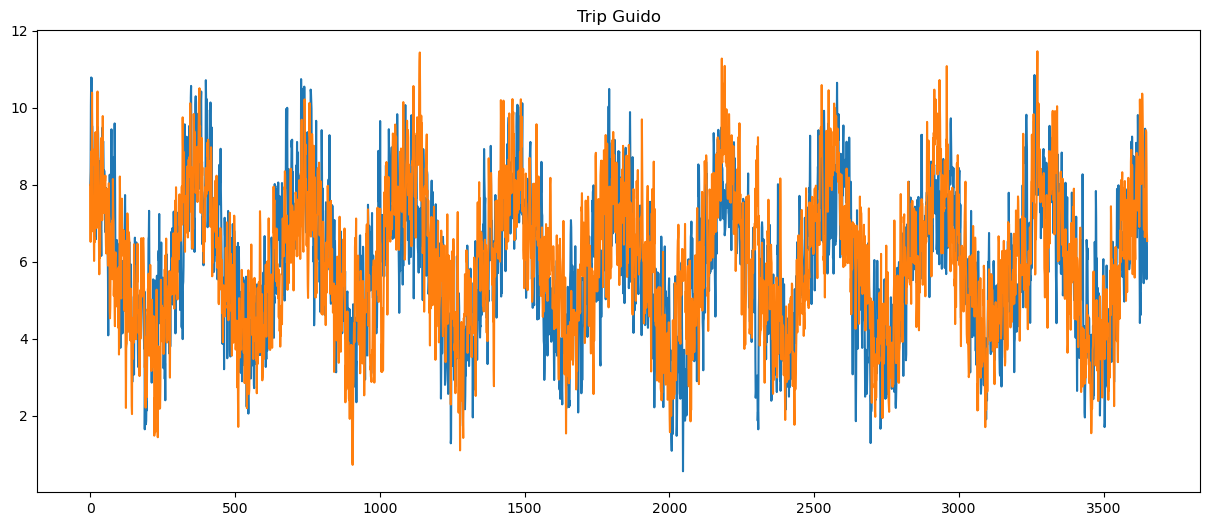

In [43]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['regional wind'])
plt.title("Trip Original")
# plt.show()

# graficar modelo predicgo
days = np.arange(0, 365 * YEARS, 1)

print(kappa, sigma)
trip_guido = simulateTrip(days, 109, sigma,S0=8)
# plt.figure(figsize=(15, 6))
plt.plot(trip_guido)
plt.title("Trip Guido")
plt.show()




## Calculamos Beta y Gamma

In [44]:
# new column with the diff between one day and the previous one

data["diff_wind_gap"] = data["wind gap norte sur"].diff().shift(-1)

data.head()

,dia,regional wind,wind gap norte sur,diff_wind,X1,diff_wind_gap
0,1,8.000000,0.000000,0.346296,0.000000,0.181523
1,2,8.346296,0.181523,1.716019,-0.000950,0.007120
2,3,10.062316,0.188643,0.729021,-0.005653,-0.117558
3,4,10.791337,0.071085,-0.037244,-0.007655,0.007358
4,5,10.754093,0.078442,0.017364,-0.007558,0.563745


In [45]:
# Diferencia entre molinos

#Di+1 = Di −βDi∆ + γ√∆ Wi (2)
#Di+1 - Di = βDi∆ + 0 (2)

# Calcular las diferencias Y_i = D_{i+1} - D_i
data['diff_wind_gap'] = data['wind gap norte sur'].diff().shift(-1)

# Calcular X1_i = (-Di) * Δ 
data['X_wind_gap'] = -1 *data["wind gap norte sur"][1:] * DELTA 

# Calcular W_i como el residuo de Y y X1
# Suponiendo que tienes alguna estimación de W_i, si no, deberás calcularla
# W_i es N(0,1) distribuido normalmente, por lo que puedes modelarlo a partir del residuo
# Por simplicidad, puedes asumir que W_i es un vector aleatorio para fines de regresión.

# Crear el modelo de regresión
X_wind_gap = data[['X_wind_gap']][1:-1]
Y_wind_gap = data[['diff_wind_gap']][1:-1]

# Ajustar el modelo de regresión
model = LinearRegression()
model.fit(X_wind_gap, Y_wind_gap)

# Obtener el valor de beta (pendiente)
print(model.coef_)
beta = model.coef_[0][0]


print(f"Valor estimado de beta: {beta}")


[[48.37684938]]
Valor estimado de beta: 48.37684937653269


In [46]:
# Calcular los residuos de la regresión
error_WG = Y_wind_gap - model.predict(X_wind_gap)
var_WG = error.var()
gamma = np.sqrt(var_WG / DELTA)

print(f"Valor estimado de gamma: {gamma}")

Valor estimado de gamma: 16.047720266718766


In [47]:
beta, gamma

(48.37684937653269, 16.047720266718766)

48.37684937653269 16.047720266718766


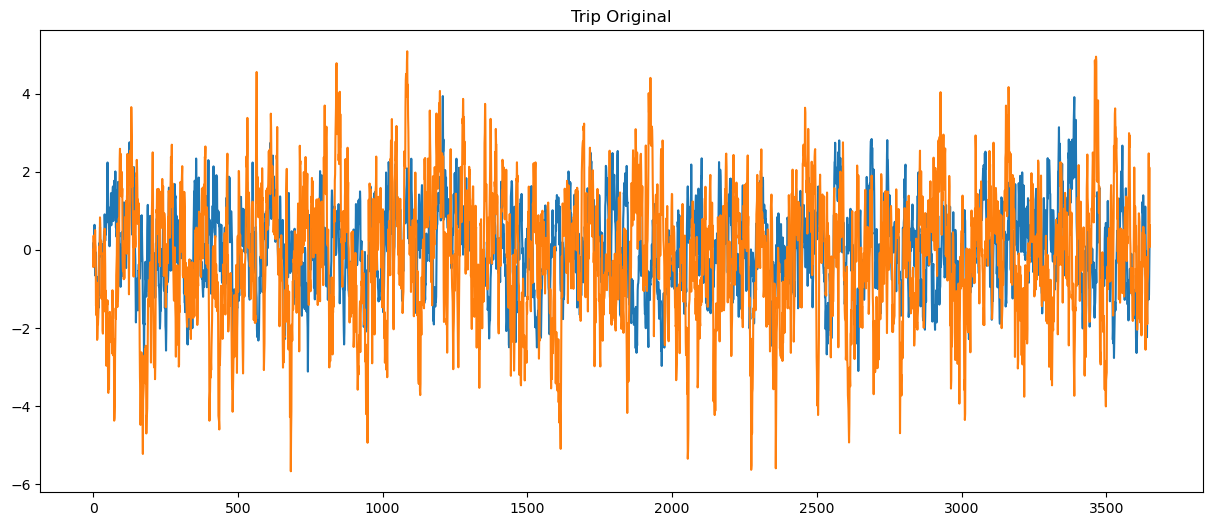

In [62]:
plt.figure(figsize=(15, 6))

# graficar data
plt.plot(data['wind gap norte sur'])
plt.title("Trip Original")
# plt.show()

# graficar modelo predicgo
days = np.arange(0, 365 * YEARS, 1)

print(beta, gamma)
trip_diff = simulateDiffTrip(beta, gamma)
# print(trip_diff)
# trip_guido = simulateTripNorteSUr(days, beta, gamma,S0=8)
plt.plot(trip_diff)
# plt.title("Trip Guido")
plt.show()

In [72]:
def theta_i(i):
    num = 6 + 2 * np.cos(2 * np.pi * i / 365)
    return num

In [73]:
def simulacion(S_i, kappa, sigma, t_i, cant_caminos):
    S = np.zeros((cant_caminos, t_i))
    Z = np.random.normal(0, 1, (cant_caminos, t_i))
    S[:,0] = S_i
    for t in range(1, t_i):
        S[:,t] = S[:, t-1] + kappa * (theta_i(np.zeros(cant_caminos) + t) - S[:, t-1]) * DELTA + np.sqrt(DELTA) * Z[:,t] * sigma
    return S    

In [81]:
M = 200
simulations = simulacion(S0, kappa, sigma, 1, data.shape[0], M)

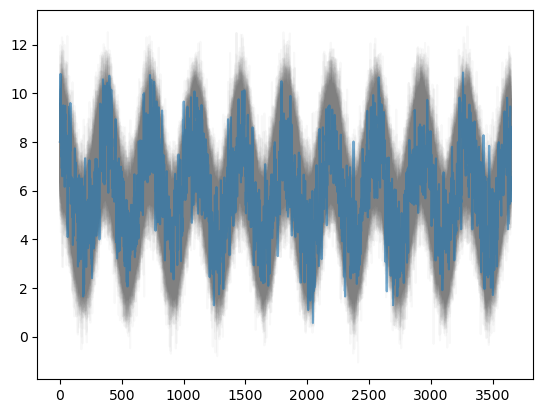

In [83]:
# Plot data 

# Plot simulation
for i in range(M):
    # color gray and alpha 0.1
    plt.plot(simulations[i,:], color='gray', alpha=0.05)

plt.plot(data['regional wind'], alpha=0.6)
plt.show()